Import and install libraries

In [ ]:
%%capture
!pip install transformers datasets pandas scikit-learn torch gradio

In [ ]:

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from torch.utils.data import DataLoader, TensorDataset
import gradio as gr


In [ ]:
import os
import matplotlib.pyplot as plt

load dataset

In [ ]:
# RUN
# connect google drive on the notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:

train_dataset_path = '/content/drive/MyDrive/DATASETS/75% smishing - 25% ham (train).csv' # change datapath
test_dataset_path = '/content/drive/MyDrive/DATASETS/testing dataset.csv' # change datapath

# Load the train and test datasets into dataframes
train_df = pd.read_csv(train_dataset_path, encoding='latin-1')
test_df = pd.read_csv(test_dataset_path, encoding='latin-1')


In [ ]:
# Print the first 5 texts from the training dataset
print("First 5 texts from the training dataset:")
print(train_df['TEXT'].head(5))

# Print the first 5 texts from the testing dataset
print("\nFirst 5 texts from the testing dataset:")
print(test_df['TEXT'].head(5))


First 5 texts from the training dataset:
0    congratulations natanggap mo ang 5677p maclaim...
1    phpocket hi mayroon kang 50000 pesos installme...
2    phpocket hi mayroon kang 46000 pesos installme...
3    lucky7charm.uk claim here nanalo ka ng p9178 m...
4    binabati kita sa pagkapanalo ng masuwerteng pr...
Name: TEXT, dtype: object

First 5 texts from the testing dataset:
0    sali na sa spins round challenge at manalo ng ...
1    dive into a pool of joy at panaloka claim your...
2    1 slash 2 notice from kopiko blanca inc maam s...
3    bingo plus alert subukan ang iyong swerte at k...
4    chickana09 may pinamimigay kaming free credits...
Name: TEXT, dtype: object


pre-processing

In [ ]:
import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Regex to detect and mask links before removing special characters
    url_pattern = re.compile(r'(?:(?:https?|ftp):\/\/)?(?:[\w-]+\.)+[a-z]{2,6}(?:\/[\w\-.\/?%&=]*)?', re.IGNORECASE)
    text = url_pattern.sub('', text) #remove links

    # Correct common Taglish misspellings and shortcuts
    corrections = {
        "kits": "kita",
        "d2": "dito",
        "tnx": "thanks",
        "wla": "wala",
        "pde": "pwede",
        "sampl:": "sample",
        "nyo": "niyo",
        "pls": "please",
        "plz": "please",
        "dun": "doon",
        "nlng": "na lang",
        "txtback": "text back",
        "txt" : "text",
        "teks": "text",
        "sory": "sorry",
        "sge": "sige",
        "dalahin": "dalhin",
        "nn": "noon",
        "avbl": "available",
        "yong": "yung",
        "mna": "muna",
        "reachedule": "reschedule",
        "di": "hindi",
        "e": "eh",
        "u": "you",
        "pts": "points",
        "msg": "message",
        "dw": "daw",
        "nla": "nila",
        "d": "hindi",
        "bnda": "banda",
        "sc@tter": "scatter",
        "fb": "facebook",
        "dto": "dito",
        "mmya": "mamaya",
        "dyan": "diyan",
        "mu": "mo",
        "khapon": "kahapon",
        "ksi": "kasi",
        "kc": "kasi",
        "kmi": "kami",
        "wla": "wala",
        "yng": "yung",
        "pra": "para",
        "mgawan": "magawan",
        "oks": "okay",
        "dept": "department",
        "pngload": "pangload",
        "ngyn": "ngayon",
        "pano": "paano",
        "pno" : "paano",
        "nagawa": "nagawa",
        "we're": "we are",
        "dun": "doon",
        "ty": "thank you",
        "te": "ate",
        "c": "si",
        "lowbat": "low battery",
        "cp": "cellphone",
        "blk": "block",
        "w/":"with",
        "reg":"register",
        "+" : "plus",
        "%" : "percent",
        "norem":"meron",
        "mag-expire":"mag expire",
        "w/out":"without",
        "cal":"call",
        "imsg": "imessage",
        "maka2": "makaka",
        "na-excite": "naexcite",
        "otw": "on the way",
        "mam": "maam",
        "anjan": "andiyan",
        "san": "saan",
        "boi": "boy",
        "woi": "hoy",
        "pres": "president",
        "teh": "ate",
        "bal": "balance",
        "gb": "gigabyte",
        "wag": "huwag",
        "ur": "your",
        "loc": "location",
        "mlpit": "malapit",
        "n": "na",
        "g": "go",
        "e": "eh",
        "nc": "nice",
        "skl": "share ko lang",
        "kmsta": "kumusta",
        "ty": "thank you",
        "tenkyu": "thank you",
        "bka": "baka",
        "dba": "diba",
        "db": "diba",
        "btw": "by the way",
        "w8": "wait",
        "fyi": "for your information",
        "afaik": "as far as i know",
        "wer": "where",
        "brb":"be right back",
        "afk":"away from keyboard",
        "luv":"love",
        "labyu": "love you",
        "mb": "my bad",
        "nuyan":"ano yan",
        "bc": "busy",
        "huyy":"huy",
        "atbp":  "at iba pa",
        "sa'yo": "sayo",
        "pawer": "power",
        "'yan": "iyan",
        "2log": "tulog",
        "dn": "din",
        "ung": "iyong",
        "gudnayt": "good night",
        "nvm": "never mind",
        "idk": "i dont know",
        "g": "go",
        "gudluck": "good luck",
        "omw": "on my way",
        "l8": "late",
        "ol": "online",
        "slr": "sorry late reply",
        "hm": "how much",
        "pm": "private message",
        "gege": "sige",
        "gg": "good game",
        "dm":"direct message",
        "rly":"really",
        "ala": "wala",
        "iyk":"iyak",
        "sry":"sorry",
        "nmn":"naman",
        "tas":"tapos",
        "di":"hindi",
        "dasurv":"deserve",
        "charot":"joke",
        "cu":"see you",
        "ily":"i love you",
        "imy":"i miss you",
        "4e":"forever",
        "tmi":"too much information",
        "hmu":"hit me up",
        "idc":"i dont care",
        "imo":"in my opinion",
        "brb":"be right back",
        "asap":"as soon as possible",
        "lol":"laugh out loud",
        "pov":"point of view",
        "tbh":"to be honest",
        "g2g":"got to go",
        "gtg":"got to go",
        "tgt":"together",
        "ttyl":"talk to you later",
        "msg":"message",
        "dm":"direct message",
        "pm":"private message",
        "jk":"just kidding",
        "nsfw":"not safe for work",
        "gl":"good luck",
        "bff":"best friend forever",
        "fyi":"for your information",
        "irl":"in real life",
        "aka":"also known as",
        "2day":"today",
        "2morrow":"tomorrow",
        "2nite":"tonight",
        "nyt":"night",
        "wru":"where are you",
        "hru":"how are you",
        "ikr":"i know right",
        "bf":"boyfriend",
        "lmk":"let me know",
        "bro":"brother",
        "wknd":"weekend",
        "ic":"i see",
        "ur":"your",
        "xoxo":"hugs and kisses",
        "omg":"oh my god",
        "teks":"text",
        "wer":"where",
        "hir":"here",
        "syug":"guys",
        "guize":"guys",
        "omw":"on my way",
        "gbu":"god bless you",
        "ol":"online",
        "slr":"sorry late reply",
        "besh":"best friend",
        "pre":"pare",
        "kyah":"kuya",
        "hm":"how much",
        "lp":"lowest price",
        "skl":"share ko lang",
        "fkl":"flex ko lang",
        "ge":"sige",
        "ftw":"for the win",
        "gg":"good game",
        "w":"winner",
        "teka":"hintay ka",
        "meron":"mayroon",
        "don":"doon",
        "nong":"noong",
        "dat":"dapat",
        "comfy":"comfortable",
        "vacay":"vacation",
        "lab":"laboratory",
        "veggies": "vegetables",
        "info":"information",
        "ref":"refrigerator",
        "vocab":"vocabulary",
        "idts":"i dont think so",
        "a3": "anyplace anytime anywhere",
        "gud":"good",
        "lamats":"salamat",
        "hnd":"hindi",
        "req":"require",
        "reqs":"requirements",
        "kya":"kuya",
        "henlo":"hello",
        "eung":"iyong",
        "eun":"yun",
        "pa'no":"paano",
        "fr":"for real",
        "sus":"suspicious",
        "abt":"about",
        "ayow":"ayun",
        "lu2":"luto",
        "dyaan": "diyan",
        "mi": "mommy",
        "mami": "mommy",
        "kk":"okay",
        "leyt":"late",
        "tenks":"thanks",
        "lodi":"idol",
        "aq":"ako",
        "ky":"kay",
        "kaw":"ikaw",
        "ma2log":"matulog",
        "rw":"raw",
        "cnb":"sinabi",
        "welcum":"welcome",
        "mgkano":"magkano",
        "mgkanu":"magkano",
        "wc":"welcome",
        "and2": "andito",
        "k": "ka"
    }
    for key, value in corrections.items():
        text = re.sub(rf'\b{re.escape(key)}\b', value, text)

    # Remove special characters, except brackets
    # This regex replaces unwanted characters while keeping the square brackets intact
    text = re.sub(r'[^a-zA-Z0-9\s\[\]]+', '', text)  # Allow alphanumeric, space, and brackets
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces

    return text

# Apply the preprocessing function to both train and test datasets
train_df['TEXT'] = train_df['TEXT'].apply(preprocess_text)
test_df['TEXT'] = test_df['TEXT'].apply(preprocess_text)




Checking if the pre-processing is implemented

In [ ]:
import pandas as pd

# Set pandas option to display the full content of text
pd.set_option('display.max_colwidth', None)

# Print the first 5 preprocessed texts from the training dataset
print("First 5 preprocessed texts from the training dataset:")
print(train_df['TEXT'].head(5))

# Print the first 5 preprocessed texts from the testing dataset
print("\nFirst 5 preprocessed texts from the testing dataset:")
print(test_df['TEXT'].head(5))

# Optionally, reset the setting back to the default
pd.reset_option('display.max_colwidth')

First 5 preprocessed texts from the training dataset:
0                                      congratulations natanggap mo ang 5677p maclaim ito sa loob ng 24 oras pindutin ang link
1                 phpocket hi mayroon kang 50000 pesos installment loan na pwede ng iwithdraw pakiclick ang link para magapply
2               phpocket hi mayroon kang 46000 pesos installment loan na pwede ng iwithdraw paki click ang link para mag apply
3                 claim here nanalo ka ng p9178 maglagay lamang ng p100 upang makuha and panalo sa aming 24 7 customer support
4    binabati kita sa pagkapanalo ng masuwerteng premyo premyo p3998 mangyaring iclick upang magwithdraw sa loob ng 24 na oras
Name: TEXT, dtype: object

First 5 preprocessed texts from the testing dataset:
0                                                                                                                                                  sali na sa spins round challenge at manalo ng yamaha mio gravis huwag palampasin ang

tokenize

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt')

train_encodings = tokenizer(list(train_df['TEXT']), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_df['TEXT']), truncation=True, padding=True, max_length=128)

train_labels = torch.tensor([1 if label == 'smishing' else 0 for label in train_df['LABEL']])
test_labels = torch.tensor([1 if label == 'smishing' else 0 for label in test_df['LABEL']])

# Convert lists to PyTorch tensors
train_encodings = {key: torch.tensor(val) for key, val in train_encodings.items()}
test_encodings = {key: torch.tensor(val) for key, val in test_encodings.items()}

# Create TensorDatasets using PyTorch tensors
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenized sample text in training and testing dataset


In [ ]:
# Print the first 5 tokenized messages from the training dataset
print("First 5 tokenized texts from the training dataset:")
for i, tokenized in enumerate(train_encodings['input_ids'][:5]):
    print(f"Original Text {i+1}: {train_df['TEXT'].iloc[i]}")
    print(f"Tokenized Text {i+1}: {tokenized.tolist()}\n")

# Print the first 5 tokenized messages from the testing dataset
print("First 5 tokenized texts from the testing dataset:")
for i, tokenized in enumerate(test_encodings['input_ids'][:5]):
    print(f"Original Text {i+1}: {test_df['TEXT'].iloc[i]}")
    print(f"Tokenized Text {i+1}: {tokenized.tolist()}\n")

First 5 tokenized texts from the training dataset:
Original Text 1: congratulations natanggap mo ang 5677p maclaim ito sa loob ng 24 oras pindutin ang link
Tokenized Text 1: [0, 242799, 5256, 24, 103394, 931, 348, 190, 170242, 254, 291, 164779, 4627, 57, 29253, 234, 744, 34849, 6, 77046, 48635, 348, 3126, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Original Text 2: phpocket hi mayroon kang 50000 pesos installment loan na pwede ng iwithdraw pakiclick ang link para magapply
Tokenized Text 2: [0, 11521, 771, 27853, 1274, 144621, 5854, 190, 28568, 102523, 20600, 674, 111628, 24, 81015, 234, 17, 76228, 86905, 89680, 123278, 348, 3126, 121, 1697, 9007, 538, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

model initialization


In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


layer freezing

In [ ]:

# Custom function to freeze/unfreeze layers
def set_layer_freeze(model, freeze_layers=[]):
    for i, layer in enumerate(model.roberta.encoder.layer):
        for param in layer.parameters():
            param.requires_grad = False if i in freeze_layers else True

# FREEZE THE LAYER
set_layer_freeze(model, freeze_layers=[0, 2, 4, 6, 8, 10]) #freeze the layers in the [] ex. [1, 2, 3]

#on this case, alternate layers are frozen


NameError: name 'model' is not defined

setting device and optimizer

In [ ]:
# RUN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


model training (comment out the code when training is done)

In [ ]:

def train(model, train_loader):
    model.train()
    for epoch in range(3):  # Train for 3 epochs
        total_loss = 0
        for batch in train_loader:  # FEED THE DATA
            inputs, masks, labels = [x.to(device) for x in batch]
            model.zero_grad()
            outputs = model(input_ids=inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # don't forget to comment when training
            # Check gradients for frozen layers
            for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:  # Check the frozen layers
                for param in model.roberta.encoder.layer[i].parameters():
                    if param.grad is not None:
                        print(f'Layer {i} Parameter Gradient: {param.grad.norm()}')
                    else:
                        print(f'Layer {i} Parameter Gradient: None (Frozen)')


        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

train(model, train_loader)


save trained model to gdrive (comment out the code when training is done and saved)

In [ ]:

model.save_pretrained('/content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/TRAINED MODEL') #change datapath


load the saved trained model

In [ ]:

from transformers import XLMRobertaForSequenceClassification

# Load the trained model from the specified directory on Google Drive
model = XLMRobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/TRAINED MODEL') # change datapath, copy the datapath where you saved the train model

# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device (GPU/CPU)
model.to(device)


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

model testing


In [ ]:

import pandas as pd
from IPython.display import display
import os

def evaluate_and_display(model, test_loader, test_texts, output_filename='75s-25h ALTERNATE LAYERS_TESTING RESULT.csv'): # you can change the file name, should be .csv
    all_preds = []
    all_labels = []
    all_texts = []
    prediction_labels = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            inputs, masks, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=inputs, attention_mask=masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Extend the predicted and actual labels, and add the corresponding text
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_texts.extend(test_texts[i * test_loader.batch_size:(i + 1) * test_loader.batch_size])

    # Convert numeric predictions to "Smishing" and "Ham"
    for pred in all_preds:
        prediction_labels.append('Smishing' if pred == 1 else 'Ham')

    # Create a DataFrame to display the text, actual label, and predicted label
    result_df = pd.DataFrame({
        'Text': all_texts,
        'Actual Label': ['Smishing' if label == 1 else 'Ham' for label in all_labels],
        'Predicted Label': prediction_labels
    })

    # Display the DataFrame interactively
    display(result_df)  # This will display it nicely in Jupyter or Colab

    # Save the DataFrame to CSV
    csv_path = os.path.join('/content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/RESULTS', output_filename) # change datapath, datapath of result
    result_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # Calculate evaluation metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    return acc, precision, recall, f1, csv_path, all_labels, all_preds

# Example usage
test_texts = test_df['TEXT'].tolist()
acc, precision, recall, f1, csv_file, all_labels, all_preds = evaluate_and_display(model, test_loader, test_texts)

print(f'Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')
print(f"CSV file created: {csv_file}")


,Text,Actual Label,Predicted Label
0,sali na sa spins round challenge at manalo ng ...,Smishing,Smishing
1,dive into a pool of joy at panaloka claim your...,Smishing,Smishing
2,1 slash 2 notice from kopiko blanca inc maam s...,Smishing,Smishing
3,bingo plus alert subukan ang iyong swerte at k...,Smishing,Smishing
4,chickana09 may pinamimigay kaming free credits...,Smishing,Smishing
...,...,...,...
295,j and t delivery tn 971619066857 rider ocwnels...,Ham,Ham
296,received na po sa guard parcel niyo,Ham,Ham
297,food panda po dito na po,Ham,Ham
298,j and t delivery tn 971607379413 rider nico lo...,Ham,Ham


Results saved to /content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/RESULTS/75s-25h ALTERNATE LAYERS_TESTING RESULT.csv
Accuracy: 0.9133333333333333, Precision: 0.8827160493827161, Recall: 0.9533333333333334, F1-score: 0.9166666666666666
CSV file created: /content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/RESULTS/75s-25h ALTERNATE LAYERS_TESTING RESULT.csv


Getting the confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import confusion_matrix

# Calculate and display the confusion matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
print(f"Confusion Matrix:\nTrue Positives (TP): {tp}\nTrue Negatives (TN): {tn}\nFalse Positives (FP): {fp}\nFalse Negatives (FN): {fn}")

Confusion Matrix:
True Positives (TP): 143
True Negatives (TN): 131
False Positives (FP): 19
False Negatives (FN): 7


layer by layer evaluation

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Layer 0 similarity to input embedding: 1.0000
	• CLS Softmax probabilities at Layer 0: HAM: 0.4694, SMISHING: 0.5306
	• Softmax probabilities at Layer 0 for token "<s>": HAM: 0.4694, SMISHING: 0.5306
	• Softmax probabilities at Layer 0 for token "▁bingo": HAM: 0.4456, SMISHING: 0.5544
	• Softmax probabilities at Layer 0 for token "▁plus": HAM: 0.5306, SMISHING: 0.4694
	• Softmax probabilities at Layer 0 for token "▁alert": HAM: 0.5631, SMISHING: 0.4369
	• Softmax probabilities at Layer 0 for token "▁su": HAM: 0.5772, SMISHING: 0.4228
	• Softmax probabilities at Layer 0 for token "bukan": HAM: 0.4255, SMISHING: 0.5745
	• Softmax probabilities at Layer 0 for token "▁ang": HAM: 0.5484, SMISHING: 0.4516
	• Softmax probabilities at Layer 0 for token "▁iyong": HAM: 0.4116, SMISHING: 0.5884
	• Softmax probabilities at Layer 0 for token "▁s": HAM: 0.5030, SMISHING: 0.4970
	• Softmax probabilities at Layer 0 for token "werte": HAM: 0.5038, SMISHING: 0.4962
	• Softmax probabilities at Layer 0 fo

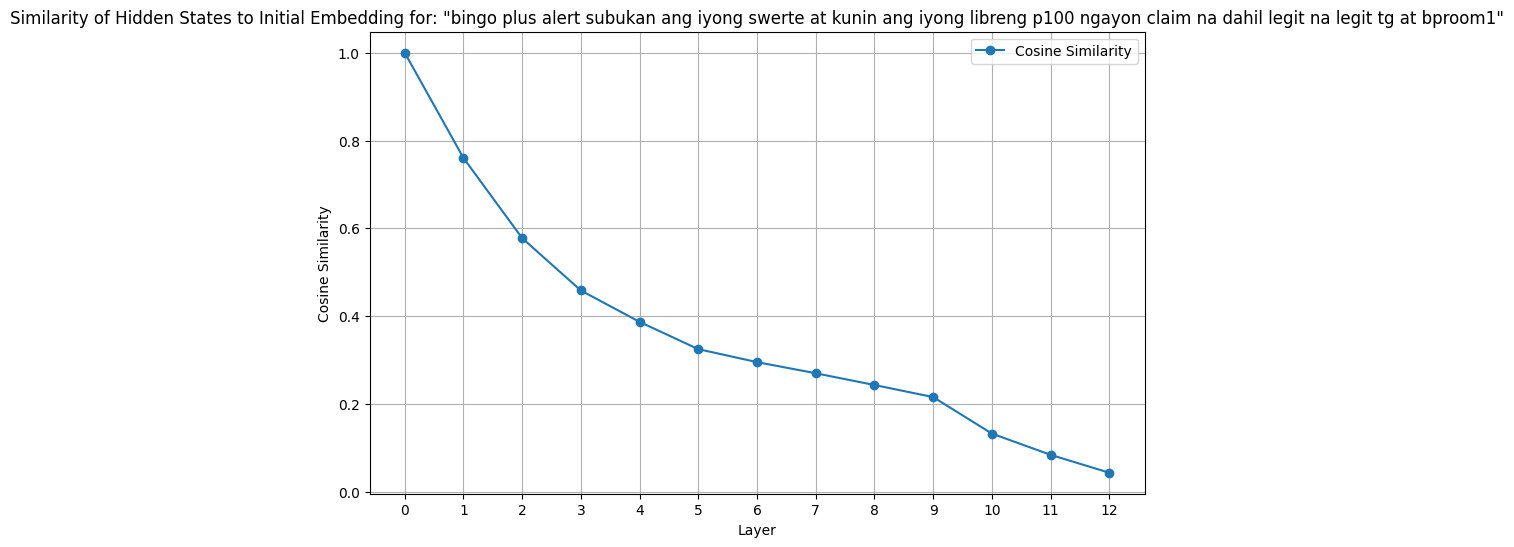

In [ ]:

import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch.nn.functional as F
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

# Load the model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/TRAINED MODEL') # change datapath,  copy the datapath where you saved the train model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')  # Initialize the tokenizer

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def layer_by_layer_evaluation(model, text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    hidden_states = model.roberta(tokens['input_ids'], output_hidden_states=True).hidden_states

    similarities = []
    result_str = ""

    initial_embedding = hidden_states[0][0].detach().cpu().numpy()

    # Get token text from the tokenizer
    token_texts = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].cpu().numpy())

    # Loop through each layer
    for i, state in enumerate(hidden_states):
        layer_embedding = state[0].detach().cpu().numpy()
        similarity = cosine_similarity(initial_embedding.reshape(1, -1), layer_embedding.reshape(1, -1)).mean()
        similarities.append(similarity)

        # Use the CLS token embedding for classification
        cls_embedding = state[:, 0, :].unsqueeze(0)  # Shape: (1, 1, hidden_size)

        # Get the classifier outputs for the CLS token
        classifier_outputs = model.classifier(cls_embedding)
        softmax_probs_cls = F.softmax(classifier_outputs, dim=1)

        # Extract probabilities for the whole text based on CLS token
        ham_prob_cls = softmax_probs_cls[0][0].item()  # Probability for 'HAM'
        smishing_prob_cls = softmax_probs_cls[0][1].item()  # Probability for 'SMISHING'

        result_str += f'Layer {i} similarity to input embedding: {similarity:.4f}\n'
        result_str += f'\t• CLS Softmax probabilities at Layer {i}: HAM: {ham_prob_cls:.4f}, SMISHING: {smishing_prob_cls:.4f}\n'

        # Calculate softmax probabilities for each token at the current layer
        token_probs = []
        for j in range(state.size(1)):  # Loop through each token in the batch
            token_cls_embedding = state[:, j, :].unsqueeze(0)  # Shape: (1, 1, hidden_size)
            token_output = model.classifier(token_cls_embedding)
            token_softmax = F.softmax(token_output, dim=1).detach().cpu().numpy()[0]  # Get softmax probabilities for this token
            token_probs.append(token_softmax)

            # Format for output
            ham_prob_token = token_softmax[0]  # Probability for 'HAM'
            smishing_prob_token = token_softmax[1]  # Probability for 'SMISHING'
            result_str += f'\t• Softmax probabilities at Layer {i} for token "{token_texts[j]}": HAM: {ham_prob_token:.4f}, SMISHING: {smishing_prob_token:.4f}\n'

    # Final softmax probabilities
    final_softmax_probs = softmax_probs_cls.detach().cpu().numpy()
    result_str += f"Final Softmax probabilities for '{text}' [HAM %]: {final_softmax_probs[0][0]:.4f} [SMISHING %]: {final_softmax_probs[0][1]:.4f}\n"

    # Print the accumulated results
    print(result_str)

    # Plot the similarity across layers
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(similarities)), similarities, marker='o', label='Cosine Similarity')
    plt.title(f'Similarity of Hidden States to Initial Embedding for: "{text}"')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(len(similarities)))
    plt.grid(True)
    plt.legend()
    plt.show()

# Example for the first test message
layer_by_layer_evaluation(model, test_df.iloc[3]['TEXT'])



this will be the sytem

In [ ]:
import requests  # For sending requests to VirusTotal
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch.nn.functional as F
import gradio as gr
import re
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

VIRUSTOTAL_API_KEY = 'api key' # put your own VirusTotal api key


# VirusTotal URL Scan Function
def check_url_with_virustotal(url):
    api_url = f"https://www.virustotal.com/vtapi/v2/url/report"
    params = {'apikey': VIRUSTOTAL_API_KEY, 'resource': url}
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        result = response.json()
        # Check the results of VirusTotal (scan results)
        if result['response_code'] == 1:  # If the URL was scanned
            # VirusTotal may provide a 'positives' key, indicating the number of suspicious reports
            if result['positives'] > 0:  # Suspicious/malicious detected
                return True
            else:
                return False
        else:
            return False  # URL not found on VirusTotal
    else:
        return False  # Error with the API request

# Load the saved model and tokenizer from Google Drive
model = XLMRobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/EXPERIMENTS/75S-25H/6 ALTERNATE LAYERS/TRAINED MODEL')  #change datapath, copy the datapath where you saved the train model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')  # Initialize the tokenizer

# Ensure the model is in evaluation mode and move to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device (CPU or GPU)
model.eval()
model.to(device)


def preprocess_text(text):
    # Convert to lowercase
    preprocessed_text = text.lower()

    # Regex to detect and mask links before removing special characters
    url_pattern = re.compile(r'(?:(?:https?|ftp):\/\/)?(?:[\w-]+\.)+[a-z]{2,6}(?:\/[\w\-.\/?%&=]*)?', re.IGNORECASE)
    found_urls = url_pattern.findall(preprocessed_text)

    for url in found_urls:
            # Check each link with VirusTotal
            if check_url_with_virustotal(url):
                return "Smishing (the link is suspicious - VirusTotal)", None  # Directly classify as smishing if suspicious

    # Remove URLs from the text since VirusTotal didn't detect them as smishing
    preprocessed_text = url_pattern.sub('', preprocessed_text)

    # Correct common Taglish misspellings and shortcuts
    corrections = {
        "kits": "kita",
        "d2": "dito",
        "tnx": "thanks",
        "wla": "wala",
        "pde": "pwede",
        "sampl:": "sample",
        "nyo": "niyo",
        "pls": "please",
        "plz": "please",
        "dun": "doon",
        "nlng": "na lang",
        "txtback": "text back",
        "txt" : "text",
        "teks": "text",
        "sory": "sorry",
        "sge": "sige",
        "dalahin": "dalhin",
        "nn": "noon",
        "avbl": "available",
        "yong": "yung",
        "mna": "muna",
        "reachedule": "reschedule",
        "di": "hindi",
        "e": "eh",
        "u": "you",
        "pts": "points",
        "msg": "message",
        "dw": "daw",
        "nla": "nila",
        "d": "hindi",
        "bnda": "banda",
        "sc@tter": "scatter",
        "fb": "facebook",
        "dto": "dito",
        "mmya": "mamaya",
        "dyan": "diyan",
        "mu": "mo",
        "khapon": "kahapon",
        "ksi": "kasi",
        "kc": "kasi",
        "kmi": "kami",
        "wla": "wala",
        "yng": "yung",
        "pra": "para",
        "mgawan": "magawan",
        "oks": "okay",
        "dept": "department",
        "pngload": "pangload",
        "ngyn": "ngayon",
        "pano": "paano",
        "pno" : "paano",
        "nagawa": "nagawa",
        "we're": "we are",
        "dun": "doon",
        "ty": "thank you",
        "te": "ate",
        "c": "si",
        "lowbat": "low battery",
        "cp": "cellphone",
        "blk": "block",
        "w/":"with",
        "reg":"register",
        "+" : "plus",
        "%" : "percent",
        "norem":"meron",
        "mag-expire":"mag expire",
        "w/out":"without",
        "cal":"call",
        "imsg": "imessage",
        "maka2": "makaka",
        "na-excite": "naexcite",
        "otw": "on the way",
        "mam": "maam",
        "anjan": "andiyan",
        "san": "saan",
        "boi": "boy",
        "woi": "hoy",
        "pres": "president",
        "teh": "ate",
        "bal": "balance",
        "gb": "gigabyte",
        "wag": "huwag",
        "ur": "your",
        "loc": "location",
        "mlpit": "malapit",
        "n": "na",
        "g": "go",
        "e": "eh",
        "nc": "nice",
        "skl": "share ko lang",
        "kmsta": "kumusta",
        "ty": "thank you",
        "tenkyu": "thank you",
        "bka": "baka",
        "dba": "diba",
        "db": "diba",
        "btw": "by the way",
        "w8": "wait",
        "fyi": "for your information",
        "afaik": "as far as i know",
        "wer": "where",
        "brb":"be right back",
        "afk":"away from keyboard",
        "luv":"love",
        "labyu": "love you",
        "mb": "my bad",
        "nuyan":"ano yan",
        "bc": "busy",
        "huyy":"huy",
        "atbp":  "at iba pa",
        "sa'yo": "sayo",
        "pawer": "power",
        "'yan": "iyan",
        "2log": "tulog",
        "dn": "din",
        "ung": "iyong",
        "gudnayt": "good night",
        "nvm": "never mind",
        "idk": "i dont know",
        "g": "go",
        "gudluck": "good luck",
        "omw": "on my way",
        "l8": "late",
        "ol": "online",
        "slr": "sorry late reply",
        "hm": "how much",
        "pm": "private message",
        "gege": "sige",
        "gg": "good game",
        "dm":"direct message",
        "rly":"really",
        "ala": "wala",
        "iyk":"iyak",
        "sry":"sorry",
        "nmn":"naman",
        "tas":"tapos",
        "di":"hindi",
        "dasurv":"deserve",
        "charot":"joke",
        "cu":"see you",
        "ily":"i love you",
        "imy":"i miss you",
        "4e":"forever",
        "tmi":"too much information",
        "hmu":"hit me up",
        "idc":"i dont care",
        "imo":"in my opinion",
        "brb":"be right back",
        "asap":"as soon as possible",
        "lol":"laugh out loud",
        "pov":"point of view",
        "tbh":"to be honest",
        "g2g":"got to go",
        "gtg":"got to go",
        "tgt":"together",
        "ttyl":"talk to you later",
        "msg":"message",
        "dm":"direct message",
        "pm":"private message",
        "jk":"just kidding",
        "nsfw":"not safe for work",
        "gl":"good luck",
        "bff":"best friend forever",
        "fyi":"for your information",
        "irl":"in real life",
        "aka":"also known as",
        "2day":"today",
        "2morrow":"tomorrow",
        "2nite":"tonight",
        "nyt":"night",
        "wru":"where are you",
        "hru":"how are you",
        "ikr":"i know right",
        "bf":"boyfriend",
        "lmk":"let me know",
        "bro":"brother",
        "wknd":"weekend",
        "ic":"i see",
        "ur":"your",
        "xoxo":"hugs and kisses",
        "omg":"oh my god",
        "teks":"text",
        "wer":"where",
        "hir":"here",
        "syug":"guys",
        "guize":"guys",
        "omw":"on my way",
        "gbu":"god bless you",
        "ol":"online",
        "slr":"sorry late reply",
        "besh":"best friend",
        "pre":"pare",
        "kyah":"kuya",
        "hm":"how much",
        "lp":"lowest price",
        "skl":"share ko lang",
        "fkl":"flex ko lang",
        "ge":"sige",
        "ftw":"for the win",
        "gg":"good game",
        "w":"winner",
        "teka":"hintay ka",
        "meron":"mayroon",
        "don":"doon",
        "nong":"noong",
        "dat":"dapat",
        "comfy":"comfortable",
        "vacay":"vacation",
        "lab":"laboratory",
        "veggies": "vegetables",
        "info":"information",
        "ref":"refrigerator",
        "vocab":"vocabulary",
        "idts":"i dont think so",
        "a3": "anyplace anytime anywhere",
        "gud":"good",
        "lamats":"salamat",
        "hnd":"hindi",
        "req":"require",
        "reqs":"requirements",
        "kya":"kuya",
        "henlo":"hello",
        "eung":"iyong",
        "eun":"yun",
        "pa'no":"paano",
        "fr":"for real",
        "sus":"suspicious",
        "abt":"about",
        "ayow":"ayun",
        "lu2":"luto",
        "dyaan": "diyan",
        "mi": "mommy",
        "mami": "mommy",
        "kk":"okay",
        "leyt":"late",
        "tenks":"thanks",
        "lodi":"idol",
        "aq":"ako",
        "ky":"kay",
        "kaw":"ikaw",
        "ma2log":"matulog",
        "rw":"raw",
        "cnb":"sinabi",
        "welcum":"welcome",
        "mgkano":"magkano",
        "mgkanu":"magkano",
        "wc":"welcome",
        "and2": "andito",
        "k": "ka"
    }

    for key, value in corrections.items():
        preprocessed_text = re.sub(rf'\b{re.escape(key)}\b', value, preprocessed_text)

    # Remove special characters, except brackets
    preprocessed_text = re.sub(r'[^a-zA-Z0-9\s\[\]]+', '', preprocessed_text)  # Allow alphanumeric, space, and brackets
    preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text)  # Replace multiple spaces with a single space
    preprocessed_text = preprocessed_text.strip()  # Remove leading and trailing spaces

    return preprocessed_text, found_urls

# Define the layer-by-layer evaluation function
def layer_by_layer_evaluation(model, text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    hidden_states = model.roberta(tokens['input_ids'], output_hidden_states=True).hidden_states

    similarities = []
    result_str = ""

    initial_embedding = hidden_states[0][0].detach().cpu().numpy()

    # Get token text from the tokenizer
    token_texts = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].cpu().numpy())

    # Loop through each layer
    for i, state in enumerate(hidden_states):
        layer_embedding = state[0].detach().cpu().numpy()
        similarity = cosine_similarity(initial_embedding.reshape(1, -1), layer_embedding.reshape(1, -1)).mean()
        similarities.append(similarity)

        # Use the CLS token embedding for classification
        cls_embedding = state[:, 0, :].unsqueeze(0)  # Shape: (1, 1, hidden_size)

        # Get the classifier outputs for the CLS token
        classifier_outputs = model.classifier(cls_embedding)
        softmax_probs_cls = F.softmax(classifier_outputs, dim=1)

        # Extract probabilities for the whole text based on CLS token
        ham_prob_cls = softmax_probs_cls[0][0].item()  # Probability for 'HAM'
        smishing_prob_cls = softmax_probs_cls[0][1].item()  # Probability for 'SMISHING'

        result_str += f'Layer {i} similarity to input embedding: {similarity:.4f}\n'
        result_str += f'\t• CLS Softmax probabilities at Layer {i}: HAM: {ham_prob_cls:.4f}, SMISHING: {smishing_prob_cls:.4f}\n'

        # Calculate softmax probabilities for each token at the current layer
        # For token-wise probabilities, we need to apply the classifier to each token's representation
        # Instead of using model.classifier directly on the hidden states, we calculate token-wise probabilities manually
        token_probs = []
        for j in range(state.size(1)):  # Loop through each token in the batch
            token_cls_embedding = state[:, j, :].unsqueeze(0)  # Shape: (1, 1, hidden_size)
            token_output = model.classifier(token_cls_embedding)
            token_softmax = F.softmax(token_output, dim=1).detach().cpu().numpy()[0]  # Get softmax probabilities for this token
            token_probs.append(token_softmax)

            # Format for output
            ham_prob_token = token_softmax[0]  # Probability for 'HAM'
            smishing_prob_token = token_softmax[1]  # Probability for 'SMISHING'
            result_str += f'\t• Softmax probabilities at Layer {i} for token "{token_texts[j]}": HAM: {ham_prob_token:.4f}, SMISHING: {smishing_prob_token:.4f}\n'

    # Final softmax probabilities
    final_softmax_probs = softmax_probs_cls.detach().cpu().numpy()
    result_str += f"Final Softmax probabilities for '{text}' [HAM %]: {final_softmax_probs[0][0]:.4f} [SMISHING %]: {final_softmax_probs[0][1]:.4f}\n"

    plt.figure(figsize=(12, 15))
    plt.plot(range(len(similarities)), similarities, marker='o', label='Cosine Similarity')
    plt.title(f'Similarity of Hidden States to Initial Embedding for: "{text}"')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.yticks(np.arange(-0.5, 1.05, 0.05))
    plt.xticks(range(len(similarities)))
    plt.grid(True)
    plt.legend()
    plt.show()

    return result_str

def identify_smishing_tokens(model, text, smishing_threshold): #need to change, depends  on learning
    # Tokenize the input text
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    hidden_states = model.roberta(tokens['input_ids'], output_hidden_states=True).hidden_states

    # Get token text from the tokenizer
    token_texts = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].cpu().numpy())

    smishing_tokens = []  # To store tokens with high smishing probabilities

    # Analyze the softmax probabilities of tokens at the final layer (Layer 12)
    final_layer = hidden_states[12]  # The last layer (Layer 12)

    for j in range(final_layer.size(1)):  # Loop through each token
        token_embedding = final_layer[:, j, :].unsqueeze(0)  # Shape: (1, 1, hidden_size)
        token_output = model.classifier(token_embedding)
        token_softmax = F.softmax(token_output, dim=1).detach().cpu().numpy()[0]  # Get softmax probabilities

        smishing_prob_token = token_softmax[1]  # Smishing probability for this token

        # If the smishing probability is greater than the threshold, add it to the list
        if smishing_prob_token > smishing_threshold:
            smishing_tokens.append((token_texts[j], smishing_prob_token))

    return smishing_tokens

# Define the prediction function
def predict_smishing(text):
    raw_text = text

    # Preprocess text
    preprocessed_text,  found_urls = preprocess_text(raw_text)

    # If VirusTotal found a suspicious link, return smishing result immediately
    if preprocessed_text == "Smishing (the link is suspicious - VirusTotal)":
        return f"Classification: {preprocessed_text}"

    # Tokenize preprocessed text
    inputs = tokenizer(preprocessed_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # Perform layer-by-layer evaluation and return results
    layer_results = layer_by_layer_evaluation(model, preprocessed_text)

    # Perform the final prediction
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    # Output the prediction and other details
    prediction_str = "Smishing" if prediction == 1 else "Ham"

    # Final softmax probabilities
    final_softmax_probs = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    ham_prob_final = final_softmax_probs[0]
    smishing_prob_final = final_softmax_probs[1]

    smishing_threshold = smishing_prob_final - 0.2700

    # If prediction is smishing, identify and print tokens contributing to smishing
    smishing_tokens_str = ""
    if prediction == 1:  # Smishing
        smishing_tokens = identify_smishing_tokens(model, preprocessed_text, smishing_threshold)
        smishing_tokens_str += "\nTokens contributing to Smishing classification:\n"
        for token, smishing_prob in smishing_tokens:
            smishing_tokens_str += f"Token: '{token}' | Smishing Probability: {smishing_prob:.4f}\n"

    # Combine everything into the final result for display
    separator = "\n"  # You can adjust the number of dashes

    result = f"Classification: {prediction_str}\n\n"
    result += separator
    result += f"Final Softmax probabilities: HAM: {ham_prob_final:.4f}, SMISHING: {smishing_prob_final:.4f}\n\n"
    result += separator
    result += f"{smishing_tokens_str}\n"
    result += separator
    result += f"Raw Text: {raw_text}\n\n"
    result += separator
    result += f"Preprocessed Text: {preprocessed_text}\n\n"
    result += separator
    result += f"Tokenized Text: {inputs['input_ids']}\n\n"  # Display the token IDs
    result += separator
    result += f"Layer similarity to input embedding:\n{layer_results}"



    return result

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


UI of the system

In [ ]:
import gradio as gr

def create_ui():
    with gr.Blocks(css=css) as demo:
        page_state = gr.State(0)  # Initialize page state

        def update_page(page_num):
            return [gr.update(visible=(page_num == i)) for i in range(3)]

        # Page 1: Title
        with gr.Column(visible=True) as page_1:
            with gr.Row(elem_id="content"):
                gr.Markdown("<h1 id='title'>SMISHING DETECTION SYSTEM FOR CODE-MIXED MESSAGES USING TRANSFER LEARNING OF XLM-ROBERTA</h1>")
            with gr.Row(elem_id="nav_row"):
                prev_button_1 = gr.Button("Previous", elem_id="prev", visible=False)  # Keep it hidden
                next_button_1 = gr.Button("Next", elem_id="nxt")

        # Page 2: Instructions
        with gr.Column(visible=False) as page_2:
            with gr.Row(elem_id="content"):
              with gr.Row(elem_id="div"):
                gr.Markdown("<h2>Description:</h2><h4>\nThis smishing detection system combines a fine-tuned XLM-RoBERTa model with the VirusTotal API to enhance message classification. This model is trained on a Taglish dataset.</h4><br><h2>How to use:</h2><h4>\n\n1. Click 'Next' to proceed to the system.\n2.  Enter the message in the text field.\n3. Click 'Submit' to receive the classification result.</h4>")
            with gr.Row(elem_id="nav_row"):
                prev_button_2 = gr.Button("Previous", elem_id="prev")
                next_button_2 = gr.Button("Next", elem_id="nxt")

        # Page 3: Prediction
        with gr.Column(visible=False) as page_3:
            with gr.Row(elem_id="content"):
                text_input = gr.Textbox(label="Enter SMS text for classification", lines=10)
                prediction_output = gr.Textbox(label="Classification Output", interactive=False, max_lines=15, lines=15, scale=2, autoscroll=False)  # Adjust lines if needed

            with gr.Row(elem_id="nav_row"):
                prev_button_3 = gr.Button("Previous", elem_id="prev")
                submit_btn = gr.Button("Submit", elem_id="nxt")

            submit_btn.click(fn=predict_smishing, inputs=text_input, outputs=prediction_output)

        # Navigation logic
        next_button_1.click(lambda: 1, outputs=page_state)
        next_button_2.click(lambda: 2, outputs=page_state)
        prev_button_2.click(lambda: 0, outputs=page_state)
        prev_button_3.click(lambda: 1, outputs=page_state)

        # Update visibility based on the state
        page_state.change(update_page, inputs=page_state, outputs=[page_1, page_2, page_3])

    return demo

# Add custom CSS
css = """
#content{
    position: relative;
    width: 100%;  /* Fixed width */
    height: 600px;  /* Fixed height */
    margin: auto;  /* Center the container */
    border: 1px solid #ccc;  /* Optional border for visual reference */
    padding: 20px;  /* Optional padding */
}
#div {
    display: flex;  /* Use flexbox for the inner div */
    flex-direction: column;  /* Stack items vertically */
    align-items: center;  /* Center items horizontally */
    justify-content: center;  /* Center items vertically */
    border: 2px dashed red;  /* Add a border to the div */
    padding-top: 80px;
    padding-bottom: 80px
}

#title{
  padding-top: 210px;
  font-size: 4em;
    font-family: 'Roboto', sans-serif;
    text-align: center;
    margin: 0;
}

h2 {
    font-size: 3em;  /* Make h2 3x bigger */
    font-family: 'Roboto', sans-serif;  /* Change the font style */
    text-align: center;  /* Center h2 */
    margin: 0;  /* Remove default margin */
}

/* Style for h4 elements */
h4 {
    font-size: 1.5em;  /* Make h4 3x bigger than default (typically 0.5em) */
    font-family: 'Roboto', sans-serif;  /* Change the font style */

    margin: 0;  /* Remove default margin */
}
#nav_row {
    display: flex;
    justify-content: space-between;  /* Place buttons at each end */
    margin-top: 10px;  /* Space above the nav row */
}


input[type='text'], textarea {
    font-size: 23px;
}
"""

# Launch the UI
ui = create_ui()
ui.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cac7e41e1ef94fc050.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
